In [1]:
from lbmpy.session import *
from lbmpy.parameterization import ScalingWidget
from lbmpy.parameterization import Scaling

# Tutorial 04: Nondimensionalization and Scaling

## Short version

Play around with the widget below and make sure that.
If you can't see the widget start this tutorial interactively in a Jupyter notebook.

- max lattice velocity $u_l < 0.1$, ( smaller means smaller errors)
- relaxation rate should not be too close to 0 or 2, otherwise simulation might get unstable. Keep in mind that advanced models (MRT, Cumulant, Entropic) can simulate more "extreme" relaxation rates.

In [11]:
p = ScalingWidget()
p.show()

## Long version

There are three different scaling/setup strategies available. In all strategies you first have to first fix the parameters of your physical setup. These are in this example:

- typical physical length
- maximal physical velocity
- kinematic viscosity

Additionally a first guess for the spatial resolution $\Delta x$ has to be made, either by directly specifying it, or by selecting how much cells should be used to resolve the typical length. 

In the **diffusive scaling** approach, the relaxation has to be chosen/guessed. Valid values are $\omega \in (0,2)$, where values too close to the interval boundaries might lead to instable simulations. From this information the time step length and the maximum velocity in lattice units is determined. Compressibility errors and Ma-number errors get smaller with smaller lattice velocity. When using diffusive scaling, lattice velocities are decreased by a factor of 2, when doubling the spatial resolution. However also four times as many time steps have to be done in this case.

The **acoustic scaling** approach lets you choose a fixed value for the maximum lattice velocity (choose something smaller than 1, or better smaller than $0.1$ there!). Doubling the spatial resolution in this approach has the following effects: time step length decreases only by a factor of 2 instead of 4 as in diffusive scaling, the relaxation rate is chosen automatically and may tend to instable values, and since the lattice velocity is fixed, the compressibility error and Ma error remain constant.

The third scaling approach lets you choose $\Delta t$ freely, while relaxation rate and lattice velocity are determined automatically.|

## Example: Channel Flow

To illustrate these concepts, we create a scenario which is defined in physical units.
We use the `Scaling` class, that provides the basis of the widget shown above.

![](../img/channel_with_dimensions.svg)


| Quantity                        | Value                        |
| ------------------------------- | -----------------------------|
| Viscosity                       | $10^{-6} \, \frac{m^2}{s}$   |
| Time to simulate                | $3\, s$                      |
| Max. inflow velocity            | $2 \frac{cm}{s}$             |
| Resolution of cylinder diameter | $30$ cells                   |


The typical length of the scenario is chosen to be the cylinder diameter, that is resolved with 30 cells.

In [3]:
cm = 1 / 100
sc = Scaling(physical_length=0.5 * cm, physical_velocity=2*cm, kinematic_viscosity=1e-6, 
             cells_per_length=30)
scaling_result = sc.diffusive_scaling(1.9)
print(scaling_result)

DiffusiveScalingResult(dt=0.0002436647173489281, lattice_velocity=0.02923976608187137)


In the diffusive scaling approach we fix the relaxation rate and compute the time step length and the lattice velocity. Here we have to check that the lattice velocity is not too high (smaller than 0.1 as a rule of thumb).
From this information we can determine the number of time steps corresponding to the desired 3 seconds simulation time.

In [4]:
total_time_steps = round(3 / scaling_result.dt)
total_time_steps

Alternatively we could have used one of the other two scaling strategies:

In [10]:
print(sc.acoustic_scaling(dt=1e-4))
print(sc.fixed_lattice_velocity_scaling(0.1))

AcousticScalingResult(relaxation_rate=1.9577133907595927, lattice_velocity=0.012000000000000002)
FixedLatticeVelocityScalingResult(relaxation_rate=1.6949152542372883, dt=0.0008333333333333333)


The scaling class also computes the Reynolds number and grid spacing for us.

In [5]:
sc.reynolds_number, sc.dx

All *lbmpy* functions get their inputs in lattice coordinates. For geometry information this means, that all quantities have to be passed in cells. So physical quantities in meters have to be divided by dx first.

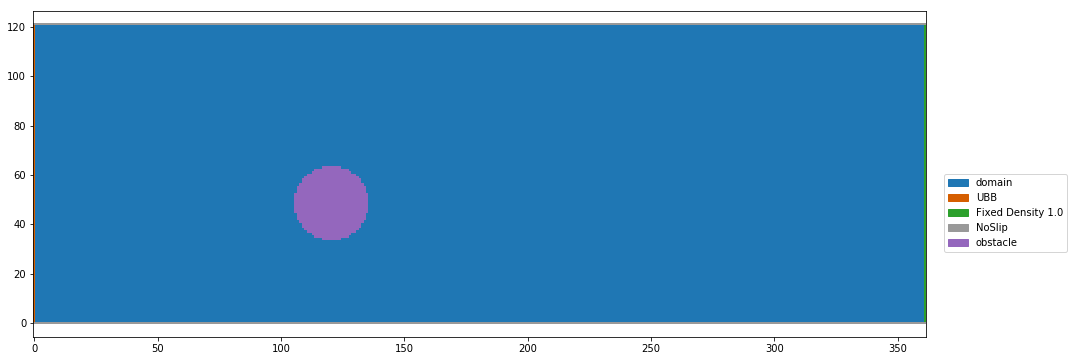

In [6]:
domain_size_in_cells = (round(6*cm / sc.dx), round(2*cm / sc.dx))
domain_size_in_cells

scenario1 = create_channel(domain_size_in_cells, u_max=scaling_result.lattice_velocity,
                           relaxation_rate=1.9, optimization={'openmp': 4})

obstacle_midpoint = (round(2 * cm / sc.dx), 
                     round(0.8*cm / sc.dx))
obstacle_radius = round(0.5 * cm / 2 / sc.dx)
add_sphere(scenario1.boundary_handling, obstacle_midpoint, obstacle_radius, NoSlip("obstacle"))
plt.boundary_handling(scenario1.boundary_handling)

Finally we run the simulation and create a video of the velocity magnitude plot.

In [7]:
if 'is_test_run' not in globals():
    scenario1.run(30000)  # initial steps

    def run():
        scenario1.run(100)
        return scenario1.velocity[:, :]

    animation = plt.vector_field_magnitude_animation(run, frames=600, rescale=True)
    set_display_mode('video')
    res = display_animation(animation)
else:
    scenario1.run(10)
    res = None
res